In [1]:
%matplotlib inline

In [2]:
from galsize_models.models import moster13_based_mock
mock = moster13_based_mock()
print("Number of model galaxies with logM* > {0:.1f} = {1:.2e}".format(np.log10(mock['mstar'].min()),len(mock)))

Number of model galaxies with logM* > 9.0 = 1.21e+06


In [3]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]
print("Number of M*-complete SDSS galaxies with good profile measurements = {0}".format(len(sdss)))
# print(sdss.keys())

Number of M*-complete SDSS galaxies with good profile measurements = 229889


In [4]:
from galsize_models.models import component_size_vs_rhalo

rvir = mock['rvir_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.15
size_seed=14041

mock['r50'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed)

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)


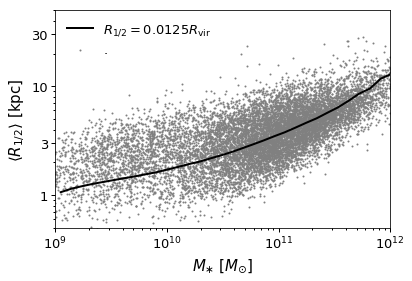

In [5]:
from matplotlib import ticker 

fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.scatter(10**sdss['logsm_bell03_meert15'][::20], 
              sdss['r50_magr_kpc_meert15'][::20], 
             s=1, color='gray', label='.')

__=ax.plot(10**logsm_mids, median_rhalf_mock, color='k', lw=2, 
          label=r'$R_{1/2} = 0.0125R_{\rm vir}$')


xmin, xmax = 10**9, 10**12
ymin, ymax = 0.5, 50
_xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
_ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
xlim = ax.set_xlim(xmin, xmax)
ylim = ax.set_ylim(ymin, ymax)
__=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
__=ax.set_yticks((1, 3, 10, 30))

ylabel=ax.set_ylabel(_ylabel)
xlabel=ax.set_xlabel(_xlabel)

leg = ax.legend()

figname = 'single_component_model_vs_sdss_one_point.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [16]:
from halotools.mock_observables import return_xyz_formatted_array, wp

def wp_samples(sample, rp_bins=np.logspace(-1, 1.25, 20), pi_max=20., period=250., 
              size_key='r50'):
    """
    """
    
    pos_all = return_xyz_formatted_array(sample['x'], sample['y'], sample['z'], 
                    velocity=sample['vz'], velocity_distortion_dimension='z', period=period)
    
    pos_small = return_xyz_formatted_array(sample['x'], sample['y'], sample['z'], 
                    velocity=sample['vz'], velocity_distortion_dimension='z', period=period, 
                    mask=(sample[size_key] < sample['r50_median']))
    pos_large = return_xyz_formatted_array(sample['x'], sample['y'], sample['z'], 
                    velocity=sample['vz'], velocity_distortion_dimension='z', period=period, 
                    mask=(sample[size_key] >= sample['r50_median']))
    
    wp_all = wp(pos_all, rp_bins, pi_max, period=period)
    wp_small = wp(pos_small, rp_bins, pi_max, period=period)
    wp_large = wp(pos_large, rp_bins, pi_max, period=period)

    rp_mids = 10**(0.5*(np.log10(rp_bins[:-1]) + np.log10(rp_bins[1:])))
    
    return rp_mids, wp_all, wp_small, wp_large

In [17]:
sample = mock[mock['mstar'] > 10**9.75]
downsampling_mask = np.random.rand(len(sample)) < 0.2
rp_mids, wp_sm9p75_mock, wp_sm9p75_small_mock, wp_sm9p75_large_mock = wp_samples(sample[downsampling_mask])

sample = mock[mock['mstar'] > 10**10.25]
downsampling_mask = np.random.rand(len(sample)) < 0.33
rp_mids, wp_sm10p25_mock, wp_sm10p25_small_mock, wp_sm10p25_large_mock = wp_samples(sample[downsampling_mask])

sample = mock[mock['mstar'] > 10**10.75]
rp_mids, wp_sm10p75_mock, wp_sm10p75_small_mock, wp_sm10p75_large_mock = wp_samples(sample)

sample = mock[mock['mstar'] > 10**11.25]
rp_mids, wp_sm11p25_mock, wp_sm11p25_small_mock, wp_sm11p25_large_mock = wp_samples(sample)

fracdiff_sm9p75_mock = (wp_sm9p75_large_mock-wp_sm9p75_small_mock)/wp_sm9p75_mock
fracdiff_sm10p25_mock = (wp_sm10p25_large_mock-wp_sm10p25_small_mock)/wp_sm10p25_mock
fracdiff_sm10p75_mock = (wp_sm10p75_large_mock-wp_sm10p75_small_mock)/wp_sm10p75_mock
fracdiff_sm11p25_mock = (wp_sm11p25_large_mock-wp_sm11p25_small_mock)/wp_sm11p25_mock

In [18]:
import os
repo_dirname = "/Users/aphearin/work/repositories/python/galsize_models"
output_subdirname = "galsize_models/measurements/data/two_point_functions"
output_dirname = os.path.join(repo_dirname, output_subdirname)

rp = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_rp.npy'))
wp_sdss_sm9p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_wp.npy'))
wp_sdss_sm9p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_small_wp.npy'))
wp_sdss_sm9p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_large_wp.npy'))
fracdiff_sm9p75_smbell = (wp_sdss_sm9p75_smbell_large-wp_sdss_sm9p75_smbell_small)/wp_sdss_sm9p75_smbell

wp_sdss_sm10p0_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_wp.npy'))
wp_sdss_sm10p0_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_small_wp.npy'))
wp_sdss_sm10p0_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_large_wp.npy'))
fracdiff_sm10p0_smbell = (wp_sdss_sm10p0_smbell_large-wp_sdss_sm10p0_smbell_small)/wp_sdss_sm10p0_smbell

wp_sdss_sm10p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_wp.npy'))
wp_sdss_sm10p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_small_wp.npy'))
wp_sdss_sm10p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_large_wp.npy'))
fracdiff_sm10p25_smbell = (wp_sdss_sm10p25_smbell_large-wp_sdss_sm10p25_smbell_small)/wp_sdss_sm10p25_smbell

wp_sdss_sm10p5_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_wp.npy'))
wp_sdss_sm10p5_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_small_wp.npy'))
wp_sdss_sm10p5_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_large_wp.npy'))
fracdiff_sm10p5_smbell = (wp_sdss_sm10p5_smbell_large-wp_sdss_sm10p5_smbell_small)/wp_sdss_sm10p5_smbell

wp_sdss_sm10p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_wp.npy'))
wp_sdss_sm10p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_small_wp.npy'))
wp_sdss_sm10p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_large_wp.npy'))
fracdiff_sm10p75_smbell = (wp_sdss_sm10p75_smbell_large-wp_sdss_sm10p75_smbell_small)/wp_sdss_sm10p75_smbell

wp_sdss_sm11_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_wp.npy'))
wp_sdss_sm11_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_small_wp.npy'))
wp_sdss_sm11_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_large_wp.npy'))
fracdiff_sm11_smbell = (wp_sdss_sm11_smbell_large-wp_sdss_sm11_smbell_small)/wp_sdss_sm11_smbell

wp_sdss_sm11p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_wp.npy'))
wp_sdss_sm11p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_small_wp.npy'))
wp_sdss_sm11p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_large_wp.npy'))
fracdiff_sm11p25_smbell = (wp_sdss_sm11p25_smbell_large-wp_sdss_sm11p25_smbell_small)/wp_sdss_sm11p25_smbell

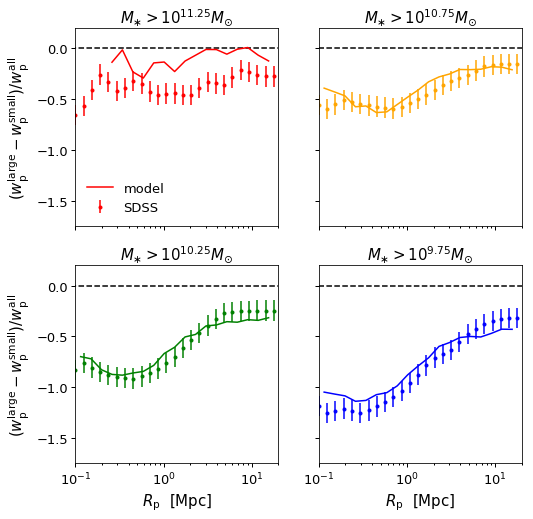

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                             figsize=(8, 8))

axes = ax1, ax2, ax3, ax4

for ax in axes:
    ylim = ax.set_ylim(-1.75, 0.2)
    xlim = ax.set_xlim(0.1, 20)
    xscale = ax.set_xscale('log')
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

    
__=ax1.errorbar(rp, fracdiff_sm11p25_smbell, 0.1, fmt='.', color='red', label='SDSS')
__=ax2.errorbar(rp, fracdiff_sm10p75_smbell, 0.1, fmt='.', color='orange')
__=ax3.errorbar(rp, fracdiff_sm10p25_smbell, 0.1, fmt='.', color='green')
__=ax4.errorbar(rp, fracdiff_sm9p75_smbell, 0.1, fmt='.', color='blue')


__=ax1.plot(rp_mids[3:], fracdiff_sm11p25_mock[3:], color='red', 
            label=r'model')
__=ax2.plot(rp_mids, fracdiff_sm10p75_mock, color='orange')
__=ax3.plot(rp_mids, fracdiff_sm10p25_mock, color='green')
__=ax4.plot(rp_mids, fracdiff_sm9p75_mock, color='blue')

__=ax1.set_title(r'$M_{\ast} > 10^{11.25}M_{\odot}$')
__=ax2.set_title(r'$M_{\ast} > 10^{10.75}M_{\odot}$')
__=ax3.set_title(r'$M_{\ast} > 10^{10.25}M_{\odot}$')
__=ax4.set_title(r'$M_{\ast} > 10^{9.75}M_{\odot}$')

ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')

leg1 = ax1.legend()

figname = 'size_clustering_ratios_alt_model_vs_sdss.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


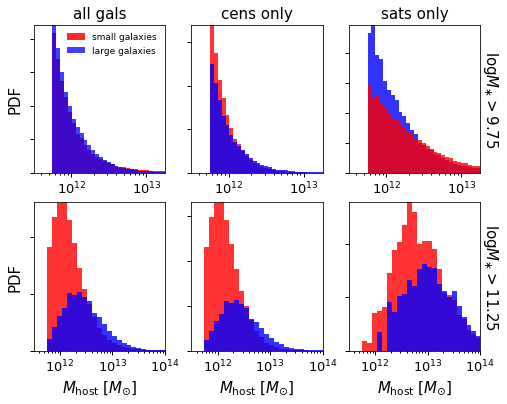

In [123]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8, 6))

axes = ax1, ax2, ax3, ax4, ax5, ax6

bins = np.logspace(11.75, 13.25, 30)

sample = mock[mock['mstar'] > 10**9.75]
small_mask = sample['r50'] < sample['r50_median']
small_sample = sample[small_mask]
large_sample = sample[~small_mask]

__=ax1.hist(small_sample['mvir_host_halo'], normed=True, bins=bins,
           alpha=0.85, color='red', label='small galaxies')
__=ax1.hist(large_sample['mvir_host_halo'], normed=True, bins=bins,
           alpha=0.75, color='blue', label='large galaxies')

__=ax2.hist(small_sample['mvir_host_halo'][small_sample['upid']==-1], normed=True, bins=bins,
           alpha=0.8, color='red', label='small galaxies')
__=ax2.hist(large_sample['mvir_host_halo'][large_sample['upid']==-1], normed=True, bins=bins,
           alpha=0.8, color='blue', label='large galaxies')

__=ax3.hist(large_sample['mvir_host_halo'][large_sample['upid']!=-1], normed=True, bins=bins,
           alpha=0.8, color='blue')
__=ax3.hist(small_sample['mvir_host_halo'][small_sample['upid']!=-1], normed=True, bins=bins,
           alpha=0.8, color='red')

sample = mock[mock['mstar'] > 10**11.25]
small_mask = sample['r50'] < sample['r50_median']
small_sample = sample[small_mask]
large_sample = sample[~small_mask]

bins = np.logspace(11.75, 14.5, 30)

__=ax4.hist(small_sample['mvir_host_halo'], normed=True, bins=bins,
           alpha=0.8, color='red', label='small galaxies')
__=ax4.hist(large_sample['mvir_host_halo'], normed=True, bins=bins,
           alpha=0.8, color='blue', label='large galaxies')

__=ax5.hist(small_sample['mvir_host_halo'][small_sample['upid']==-1], normed=True, bins=bins,
           alpha=0.8, color='red', label='small galaxies')
__=ax5.hist(large_sample['mvir_host_halo'][large_sample['upid']==-1], normed=True, bins=bins,
           alpha=0.8, color='blue', label='large galaxies')

__=ax6.hist(small_sample['mvir_host_halo'][small_sample['upid']!=-1], normed=True, bins=bins,
           alpha=0.8, color='red')
__=ax6.hist(large_sample['mvir_host_halo'][large_sample['upid']!=-1], normed=True, bins=bins,
           alpha=0.8, color='blue')


title1 = ax1.set_title(r'all gals')
title2 = ax2.set_title(r'cens only')
title3 = ax3.set_title(r'sats only')

ylabel1 = ax1.set_ylabel(r'PDF')
ylabel4 = ax4.set_ylabel(r'PDF')

for ax in axes:
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)

for ax in (ax1, ax2, ax3):
    xlim = ax.set_xlim(10**11.5, 10**13.25)
    __=ax.set_xscale('log')

for ax in (ax4, ax5, ax6):
    xlim = ax.set_xlim(10**11.5, 10**14)
    __=ax.set_xscale('log')
    xlabel = ax.set_xlabel(r'$M_{\rm host}$ [$M_{\odot}]$')

__=ax3.yaxis.set_label_position("right")
ylabel3 = ax3.set_ylabel(r'$\log M_{\ast} > 9.75$', rotation=-90, labelpad=20)
__=ax6.yaxis.set_label_position("right")
ylabel6 = ax6.set_ylabel(r'$\log M_{\ast} > 11.25$', rotation=-90, labelpad=20)

leg1 = ax1.legend(fontsize=9)

figname = 'large_small_host_halo_mass_mstar_dependence.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [8]:
np.mean(np.log10(sample['mvir_host_halo'][small_mask])),np.mean(np.log10(sample['mvir_host_halo'][~small_mask]))

(12.051837, 11.922842)

In [ ]:
np.mean(sample['upid'] != -1)

In [ ]:
len(sample), np.count_nonzero(small_mask)

In [ ]:
np.mean(sample['upid'][small_mask] != -1)

In [ ]:
np.mean(sample['upid'][~small_mask] != -1)

In [23]:
print(mock.keys())

['upid', 'mpeak', 'scale_factor_mpeak', 'x', 'y', 'z', 'zpeak', 'vmax_mpeak', 'vx', 'vy', 'vz', 'rvir_zpeak', 'vmax_at_mpeak_percentile', 'mvir_host_halo', 'spin', 'uran', 'mstar', 'mstar_moster13', 'r50', 'r50_median']
